<h1>Least-squares Optimization with Theseus</h1>
This tutorial demonstrates how to solve a curve-fitting problem with Theseus. The examples in this tutorial are inspired by the [Ceres](https://ceres-solver.org/) [tutorial](http://ceres-solver.org/nnls_tutorial.html), and structured like the [curve-fitting example](http://ceres-solver.org/nnls_tutorial.html#curve-fitting) and [robust curve-fitting example](http://ceres-solver.org/nnls_tutorial.html#robust-curve-fitting) in Ceres.

<h2>Quadratic curve-fitting</h2>
In this tutorial, we will show how we can fit a quadratic function: <i>y = ax<sup>2</sup> + b</i>

<h3>Step 0: Generating Data</h3>
We first generate data by sampling points from the quadratic function <i>x<sup>2</sup> + 0.5</i>. To this, we add Gaussian noise with <i>&sigma; = 0.01</i>.

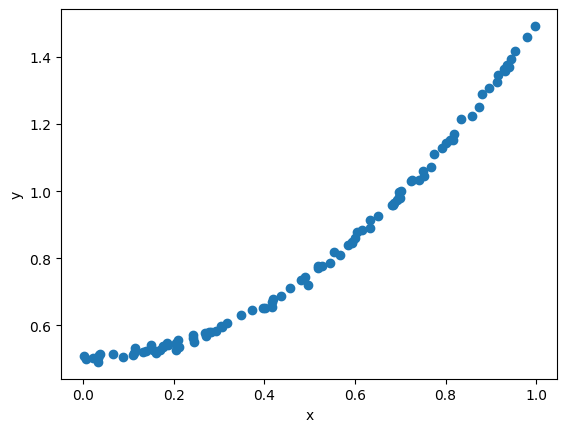

In [2]:
import torch

torch.manual_seed(0)

def generate_data(num_points=100, a=1, b=0.5, noise_factor=0.01):
    # Generate data: 100 points sampled from the quadratic curve listed above
    data_x = torch.rand((1, num_points))
    noise = torch.randn((1, num_points)) * noise_factor
    data_y = a * data_x.square() + b + noise
    return data_x, data_y

data_x, data_y = generate_data()

# Plot the data
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(data_x, data_y);
ax.set_xlabel('x');
ax.set_ylabel('y');

We demonstrate how to use Theseus to solve this curve-fitting problem in 3 steps:
<ul>
<li>Step 1: Represent data and variables
<li>Step 2: Set up optimization
<li>Step 3: Run optimization
</ul>

<h3>Step 1: Represent data and variables in Theseus</h3>
As we described in Tutorial 0, Theseus Variables are semantically divided into two main classes:
<ul>
<li><i>optimization variables</i>: those that will be modified by our non-linear least-squares optimizers to minimize the total cost function
<li><i>auxiliary variables</i>: other variables required by the cost functions to carry out the optimization, but which will not be optimized by the non-linear least-squares optimizers, e.g., application data in this example (we will see more examples of )
</ul>

Our first step is to represent the data <i>(x, y)</i> and the optimization variables (<i>a</i> and <i>b</i>) in Theseus data structures.
The optimization variables must be of type `Manifold`. For this example, we choose its `Vector` sub-class to represent <i>a</i> and <i>b</i>. Because they are one-dimensional quantities, we require only 1 degree-of-freedom in initializing these `Vector` objects. (Alternately, we could also represent both variables as a single 2-dimensional `Vector` object; however, this would change how the error functions are written.) The (auxiliary) data variables may be an instance of any `Variable` type. For this example, the type `Variable` itself suffices.

In [3]:
import theseus as th

# data is of type Variable
x = th.Variable(data_x, name="x")
y = th.Variable(data_y, name="y")

# optimization variables are of type Vector with 1 degree of freedom (dof)
a = th.Vector(1, name="a")
b = th.Vector(1, name="b")

<h3>Step 2: Set up optimization</h3> 
    
The residual errors of the least-squares fit is captured in a `CostFunction`. In this example, we will use the `AutoDiffCostFunction` provided by Theseus, which provides an easy-to-use way to capture arbitrary cost functions. The `AutoDiffCostFunction` only requires that we define the optimization variables and the auxiliary variables, and provide an error function that computes the residual errors. From there, it uses the PyTorch autograd to compute the Jacobians for the optimization variables via automatic differentiation. 

In the example below, the `quad_error_fn` captures the least-squares error of the quadratic function fitted with the two 1-dimensional `Vector` objects `a`, `b`. 

The total least-squares error can be captured by either one 100-dimensional `AutoDiffCostFunction` (where each dimension represents the error of one data point), or a set of 100 one-dimensional `AutoDiffCostFunction` (where instead each cost function captures the error of one data point). We use the former (i.e., one 100-dimensional `AutoDiffCostFunction`) in this example, but we will see examples of the latter in Tutorials 4 & 5.

Finally, we combine the cost functions into a Theseus optimization problem:
- The optimization criteria is represented by the `Objective`. This is constructed by adding all the cost functions to it.
- We can then choose an optimizer and set some of its default configuration (e.g., `GaussNewton` with `max_iterations=15` in the example below).
- The objective and its associated optimizer are then used to construct the `TheseusLayer`, which represents one layer of optimization

In [8]:
def quad_error_fn(optim_vars, aux_vars):
    a, b = optim_vars 
    x, y = aux_vars
    est = a.tensor * x.tensor.square() + b.tensor
    err = y.tensor - est
    return err

optim_vars = a, b
aux_vars = x, y
cost_function = th.AutoDiffCostFunction(
    optim_vars, quad_error_fn, 100, aux_vars=aux_vars, name="quadratic_cost_fn"
)
objective = th.Objective()
objective.add(cost_function)
optimizer = th.GaussNewton(
    objective,
    max_iterations=15,
    step_size=0.5,
)
theseus_optim = th.TheseusLayer(optimizer)

<h3>Step 3: Run optimization</h3> 
Running the optimization problem now only requires that we provide the input data and initial values, and call the forward function on the `TheseusLayer`.

The input is provided as a dictionary, where the keys represent either the optimization variables (which are paired with their initial values), or the auxiliary variables (which are paired with their data). The dictionary `theseus_inputs` shows an example of this.

With this input, we can now run the least squares optimization in Theseus. We do this by calling the `forward` function on the `TheseusLayer`. Two quantities are returned after each call to the `forward` function:
1. The `updated_inputs` object, which holds the final values for the optimized variables, along with unchanged auxiliary variable values. This allows us to use the `updated_inputs` as input to downstream functions or Theseus layers (e.g., for problems that require multiple forward passes, as we will see in Tutorial 2.)
2. The `info` object, which can track the best solution if necessary, and holds other useful information about the optimization. The best solution is useful to track because the optimization algorithm does not stop if the error increases from an earlier iteration. (The best solution is not as useful when backpropagation is carried out, because backpropagation uses the entire optimization sequence; see Tutorial 2.)

Nonlinear optimizer. Iteration: 0. Error: 38.42743682861328
Nonlinear optimizer. Iteration: 1. Error: 9.609884262084961
Nonlinear optimizer. Iteration: 2. Error: 2.405491828918457
Nonlinear optimizer. Iteration: 3. Error: 0.6043925285339355
Nonlinear optimizer. Iteration: 4. Error: 0.15411755442619324
Nonlinear optimizer. Iteration: 5. Error: 0.04154873266816139
Nonlinear optimizer. Iteration: 6. Error: 0.013406438753008842
Nonlinear optimizer. Iteration: 7. Error: 0.006370890885591507
Nonlinear optimizer. Iteration: 8. Error: 0.0046120136976242065
Nonlinear optimizer. Iteration: 9. Error: 0.0041722883470356464
Nonlinear optimizer. Iteration: 10. Error: 0.004062363877892494
Nonlinear optimizer. Iteration: 11. Error: 0.004034876357764006
Nonlinear optimizer. Iteration: 12. Error: 0.004028005059808493
Nonlinear optimizer. Iteration: 13. Error: 0.004026289563626051
Nonlinear optimizer. Iteration: 14. Error: 0.004025860223919153
Nonlinear optimizer. Iteration: 15. Error: 0.0040257535874843

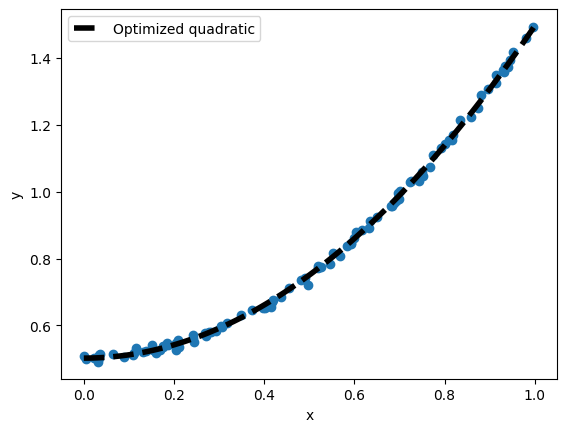

In [9]:
theseus_inputs = {
"x": data_x,
"y": data_y,
"a": 2 * torch.ones((1, 1)),
"b": torch.ones((1, 1))
}
with torch.no_grad():
    updated_inputs, info = theseus_optim.forward(
        theseus_inputs, optimizer_kwargs={"track_best_solution": True, "verbose":True})
print("Best solution:", info.best_solution)

# Plot the optimized function
fig, ax = plt.subplots()
ax.scatter(data_x, data_y);

a = info.best_solution['a'].squeeze()
b = info.best_solution['b'].squeeze()
x = torch.linspace(0., 1., steps=100)
y = a*x*x + b
ax.plot(x, y, color='k', lw=4, linestyle='--',
        label='Optimized quadratic')
ax.legend()

ax.set_xlabel('x');
ax.set_ylabel('y');

We observe that we have recovered almost exactly the original <i>a, b</i> values used in the quadratic function we sampled from.

<h2>Robust Quadratic curve-fitting</h2>

This example can also be adapted for a problem where the errors are weighted, e.g., with a Cauchy loss that reduces the weight of data points with extremely high errors. This is similar to the [robust curve-fitting example](http://ceres-solver.org/nnls_tutorial.html#robust-curve-fitting) in the Ceres solver.

In this tutorial, we make a simple modification to add a Cauchy-loss weighting to the error function: we replace the `quad_error_fn` above in the `AutoDiffCostFunction` by creating the following `cauchy_loss_quad_error_fn` that weights it.

In [10]:
def cauchy_fn(x):
    return torch.sqrt(0.5 * torch.log(1 + x ** 2))

def cauchy_loss_quad_error_fn(optim_vars, aux_vars):
    err = quad_error_fn(optim_vars, aux_vars)
    return cauchy_fn(err)

wt_cost_function = th.AutoDiffCostFunction(
    optim_vars, cauchy_loss_quad_error_fn, 100, aux_vars=aux_vars, name="cauchy_quad_cost_fn"
)

Similar to the example above, we can now construct the Theseus optimization problem with this weighted cost function: create `Objective`, an optimizer, and a `TheseusLayer`, and run the optimization.

Nonlinear optimizer. Iteration: 0. Error: 13.170896530151367
Nonlinear optimizer. Iteration: 1. Error: 5.595989227294922
Nonlinear optimizer. Iteration: 2. Error: 2.6045525074005127
Nonlinear optimizer. Iteration: 3. Error: 1.248531460762024
Nonlinear optimizer. Iteration: 4. Error: 0.6063637733459473
Nonlinear optimizer. Iteration: 5. Error: 0.2966576814651489
Nonlinear optimizer. Iteration: 6. Error: 0.14604422450065613
Nonlinear optimizer. Iteration: 7. Error: 0.0725097507238388
Nonlinear optimizer. Iteration: 8. Error: 0.03653936833143234
Nonlinear optimizer. Iteration: 9. Error: 0.018927372992038727
Nonlinear optimizer. Iteration: 10. Error: 0.01030135527253151
Nonlinear optimizer. Iteration: 11. Error: 0.0060737887397408485
Best solution: {'a': tensor([[1.0039]]), 'b': tensor([[0.5112]])}


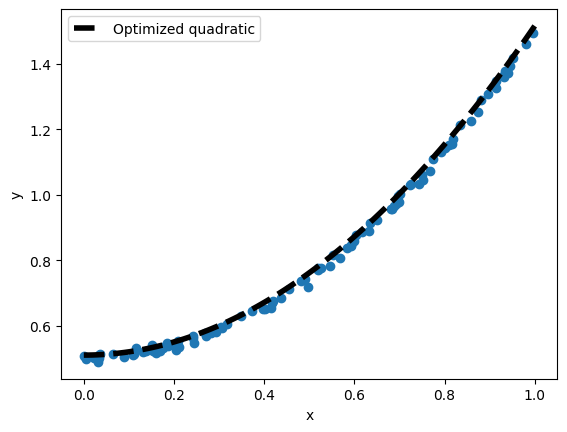

In [11]:
objective = th.Objective()
objective.add(wt_cost_function)
optimizer = th.GaussNewton(
    objective,
    max_iterations=20,
    step_size=0.3,
)
theseus_optim = th.TheseusLayer(optimizer)
theseus_inputs = {
"x": data_x,
"y": data_y,
"a": 2 * torch.ones((1, 1)),
"b": torch.ones((1, 1))
}

# We suppress warnings in this optimization call, because we observed that with this data, Cauchy 
# loss often results in singular systems with numerical computations as it approaches optimality. 
# Please note: getting a singular system during the forward optimization will throw
# an error if torch's gradient tracking is enabled.
import warnings
warnings.simplefilter("ignore")   

with torch.no_grad():
    _, info = theseus_optim.forward(
        theseus_inputs, optimizer_kwargs={"track_best_solution": True, "verbose":True})
print("Best solution:", info.best_solution)

# Plot the optimized function
fig, ax = plt.subplots()
ax.scatter(data_x, data_y);

a = info.best_solution['a'].squeeze()
b = info.best_solution['b'].squeeze()
x = torch.linspace(0., 1., steps=100)
y = a*x*x + b
ax.plot(x, y, color='k', lw=4, linestyle='--',
        label='Optimized quadratic')
ax.legend()

ax.set_xlabel('x');
ax.set_ylabel('y');

For a more efficient solution to the curve-fitting problems, one can also write a custom `CostFunction` with closed-form Jacobians, rather than use the `AutoDiffCostFunction` with torch's numerically-computed Jacobians. We show an example of this in Tutorial 3.